In [10]:
import json
import sys
import pyspark
from operator import add
from pyspark import SparkContext

## Group Test Data generation

In [11]:
lines = sc.textFile("gs://testdatakiana/tps2*",6)
rdd=lines.map(lambda x:json.loads(x))
df_16= rdd.filter(lambda x: "2019-11-16"  in x['localtime'])
df_17= rdd.filter(lambda x: "2019-11-17"  in x['localtime'])
df_18= rdd.filter(lambda x: "2019-11-18"  in x['localtime'])
df_19= rdd.filter(lambda x: "2019-11-19"  in x['localtime'])
df_20= rdd.filter(lambda x: "2019-11-20"  in x['localtime'])
df_16_mac = df_19.map(lambda x: (x["ClientMacAddr"])).distinct()
df_17_mac = df_17.map(lambda x: (x["ClientMacAddr"])).distinct()
df_18_mac = df_18.map(lambda x: (x["ClientMacAddr"])).distinct()
df_19_mac = df_19.map(lambda x: (x["ClientMacAddr"])).distinct()
df_20_mac = df_20.map(lambda x: (x["ClientMacAddr"])).distinct()
intersection_mac = (((df_16_mac.intersection(df_17_mac)).intersection(df_18_mac)).intersection(df_19_mac)).intersection(df_20_mac)
mac_id_group = intersection_mac.collect()

In [12]:
group_list = df_19.filter(lambda x: x['ClientMacAddr'] in mac_id_group)

In [13]:
group_test_df = group_list.toDF(["Building","ClientMacAddr","Level","lat","lng","localtime"])
group_test_df=group_test_df.toPandas()

/usr/lib/spark/python/pyspark/sql/session.py:360: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


In [14]:
group_test_df.shape

(451508, 6)

In [15]:
import pandas as pd
group_test_df['localtime'] = pd.to_datetime(group_test_df['localtime'], utc=True)

In [17]:
import numpy as np
macid = np.array(group_test_df.groupby(['ClientMacAddr']))

In [18]:
X=group_test_df.loc[:,['ClientMacAddr','lat','lng','localtime']]
X.head(10)


ClientMacAddr        lat        lng                        localtime
0  b8:27:eb:14:a4:88 -22.813697 -43.247597 2019-11-19 00:00:00.197000+00:00
1  b8:27:eb:14:a4:88 -22.813697 -43.247597 2019-11-19 00:00:00.197000+00:00
2  40:9b:cd:96:44:14 -22.813448 -43.247592 2019-11-19 00:00:00.287000+00:00
3  40:9b:cd:96:44:14 -22.813448 -43.247592 2019-11-19 00:00:00.288000+00:00
4  8c:f7:10:f8:c6:86 -22.815071 -43.246684 2019-11-19 00:00:00.307000+00:00
5  8c:f7:10:f8:c6:86 -22.815071 -43.246684 2019-11-19 00:00:00.307000+00:00
6  d4:c9:4b:97:da:a1 -22.815264 -43.245830 2019-11-19 00:00:00.380000+00:00
7  d4:c9:4b:97:da:a1 -22.815264 -43.245830 2019-11-19 00:00:00.380000+00:00
8  70:fd:46:da:29:b6 -22.815295 -43.246316 2019-11-19 00:00:01.348000+00:00
9  70:fd:46:da:29:b6 -22.815295 -43.246316 2019-11-19 00:00:01.348000+00:00

In [19]:
X =X.drop_duplicates(subset=None, keep='first', inplace=False)
len(X)

262841

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
import csv

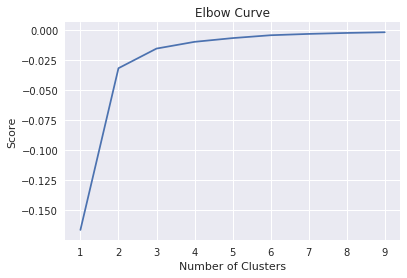

In [21]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = group_test_df[['lat']]
X_axis = group_test_df[['lng']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [22]:
kmeans = KMeans(n_clusters =15 , init ='k-means++')
kmeans.fit(X[X.columns[1:3]]) # Compute k-means clustering.
X['cluster_label'] = kmeans.fit_predict(X[X.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(X[X.columns[1:3]]) # Labels of each point
X.head(10)

ClientMacAddr        lat        lng                        localtime  \
0   b8:27:eb:14:a4:88 -22.813697 -43.247597 2019-11-19 00:00:00.197000+00:00   
2   40:9b:cd:96:44:14 -22.813448 -43.247592 2019-11-19 00:00:00.287000+00:00   
3   40:9b:cd:96:44:14 -22.813448 -43.247592 2019-11-19 00:00:00.288000+00:00   
4   8c:f7:10:f8:c6:86 -22.815071 -43.246684 2019-11-19 00:00:00.307000+00:00   
6   d4:c9:4b:97:da:a1 -22.815264 -43.245830 2019-11-19 00:00:00.380000+00:00   
8   70:fd:46:da:29:b6 -22.815295 -43.246316 2019-11-19 00:00:01.348000+00:00   
10  c0:a5:dd:17:fb:06 -22.815075 -43.245432 2019-11-19 00:00:01.550000+00:00   
12  c0:a5:dd:17:fb:e6 -22.814326 -43.246999 2019-11-19 00:00:01.551000+00:00   
14  34:69:87:12:42:b9 -22.815076 -43.245286 2019-11-19 00:00:02.266000+00:00   
16  38:01:95:38:cf:bc -22.813776 -43.247158 2019-11-19 00:00:02.287000+00:00   

    cluster_label  
0              10  
2               6  
3               6  
4              13  
6              12  
8               3  
10              0  
12              8  
14              0  
16              2

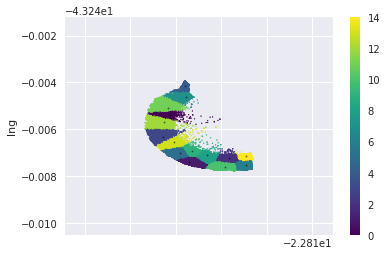

In [23]:
X.plot.scatter(x = 'lat', y = 'lng', c=labels, s=1, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=2, alpha=0.5)

In [24]:
X_labeled = X[['ClientMacAddr','cluster_label']].copy()
X_labeled.head(5)

ClientMacAddr  cluster_label
0  b8:27:eb:14:a4:88             10
2  40:9b:cd:96:44:14              6
3  40:9b:cd:96:44:14              6
4  8c:f7:10:f8:c6:86             13
6  d4:c9:4b:97:da:a1             12

In [25]:
len(X_labeled['cluster_label'].unique())

15

In [26]:
 np.array(X_labeled.groupby(['ClientMacAddr']))

array([[u'00:05:16:59:ad:2b',
                    ClientMacAddr  cluster_label
19618   00:05:16:59:ad:2b              3
19944   00:05:16:59:ad:2b              9
269876  00:05:16:59:ad:2b              3
270000  00:05:16:59:ad:2b              3
270001  00:05:16:59:ad:2b              3
270082  00:05:16:59:ad:2b             12
270158  00:05:16:59:ad:2b             12
270234  00:05:16:59:ad:2b             12
270358  00:05:16:59:ad:2b             12
270434  00:05:16:59:ad:2b              0
270443  00:05:16:59:ad:2b              0
270502  00:05:16:59:ad:2b             12
270568  00:05:16:59:ad:2b             12
270722  00:05:16:59:ad:2b             12
270794  00:05:16:59:ad:2b             12
270866  00:05:16:59:ad:2b              3
270928  00:05:16:59:ad:2b              3
271018  00:05:16:59:ad:2b              3
271090  00:05:16:59:ad:2b              3
271160  00:05:16:59:ad:2b              3
271222  00:05:16:59:ad:2b              3
271304  00:05:16:59:ad:2b              3
271358  00:05:16:59

In [27]:
kmeans.inertia_

0.006530278259517878

In [28]:
kmeans.cluster_centers_

array([[-22.81512549, -43.24538971],
       [-22.81469636, -43.24740412],
       [-22.81383183, -43.24720566],
       [-22.81527003, -43.24630234],
       [-22.8147966 , -43.24416731],
       [-22.81491251, -43.24701394],
       [-22.81344678, -43.24752429],
       [-22.81476324, -43.24461736],
       [-22.81430548, -43.24710629],
       [-22.81464038, -43.24691366],
       [-22.8139061 , -43.24758301],
       [-22.81516193, -43.24506752],
       [-22.81525383, -43.24569334],
       [-22.81503898, -43.24654715],
       [-22.81344375, -43.2471336 ]])

In [29]:
kmeans.labels_

array([10,  6,  6, ...,  2,  9,  4], dtype=int32)

In [30]:
x_lat_lng = X.copy()

In [31]:
x_lat_lng

ClientMacAddr        lat        lng  \
0       b8:27:eb:14:a4:88 -22.813697 -43.247597   
2       40:9b:cd:96:44:14 -22.813448 -43.247592   
3       40:9b:cd:96:44:14 -22.813448 -43.247592   
4       8c:f7:10:f8:c6:86 -22.815071 -43.246684   
6       d4:c9:4b:97:da:a1 -22.815264 -43.245830   
8       70:fd:46:da:29:b6 -22.815295 -43.246316   
10      c0:a5:dd:17:fb:06 -22.815075 -43.245432   
12      c0:a5:dd:17:fb:e6 -22.814326 -43.246999   
14      34:69:87:12:42:b9 -22.815076 -43.245286   
16      38:01:95:38:cf:bc -22.813776 -43.247158   
17      38:01:95:38:cf:bc -22.813776 -43.247158   
18      08:96:ad:db:dc:08 -22.815178 -43.246848   
20      00:05:9e:96:a9:fa -22.814613 -43.247464   
22      7c:5c:f8:f7:33:61 -22.814715 -43.246901   
24      b8:27:eb:6f:c2:6f -22.814536 -43.247013   
26      48:49:c7:c8:90:b8 -22.815051 -43.246340   
28      e0:9d:31:ab:11:14 -22.814964 -43.246580   
30      d0:04:01:01:39:43 -22.815315 -43.245127   
31      d0:04:01:01:39:43 -22.815315 -43.245127   
32      40:9b:cd:98:da:1c -22.815583 -43.245928   
33      40:9b:cd:98:da:1c -22.815583 -43.245928   
34      10:f1:f2:52:63:ca -22.814931 -43.244683   
36      30:4b:07:3e:ec:11 -22.814937 -43.245055   
38      00:1a:3f:19:05:52 -22.815055 -43.246451   
39      00:1a:3f:19:05:52 -22.815055 -43.246451   
40      a0:9d:c1:92:1f:5d -22.813963 -43.247112   
42      c0:25:e9:7f:32:c0 -22.814602 -43.247499   
44      c0:25:e9:7f:32:c1 -22.814788 -43.247375   
46      38:01:95:36:c0:aa -22.813347 -43.247069   
47      38:01:95:36:c0:aa -22.813347 -43.247069   
...                   ...        ...        ...   
451457  94:10:3e:0c:c2:f3 -22.813770 -43.247213   
451458  38:01:95:38:cf:bc -22.813882 -43.247192   
451460  f8:95:ea:37:48:0c -22.814746 -43.246842   
451462  b8:27:eb:fe:dc:66 -22.814800 -43.246998   
451464  10:d0:7a:7c:e0:65 -22.814811 -43.244018   
451466  38:01:95:37:74:e0 -22.814629 -43.244616   
451468  04:d4:c4:9d:4d:1f -22.814907 -43.244580   
451470  40:9b:cd:96:44:14 -22.813430 -43.247555   
451472  28:ed:e0:8a:d4:a9 -22.813427 -43.247359   
451473  28:ed:e0:8a:d4:a9 -22.813427 -43.247359   
451474  58:10:8c:82:56:27 -22.814374 -43.247489   
451475  58:10:8c:82:56:27 -22.814374 -43.247489   
451476  e0:9d:31:ab:0c:cc -22.814951 -43.246645   
451478  b8:27:eb:d5:29:27 -22.815147 -43.245825   
451480  70:fd:46:da:29:b6 -22.815368 -43.246009   
451482  0c:80:63:25:be:91 -22.814584 -43.246882   
451484  04:1b:6d:ad:d3:fe -22.814666 -43.247008   
451486  7c:5c:f8:f4:a0:83 -22.814745 -43.246910   
451488  da:0f:99:23:d7:ea -22.814933 -43.246523   
451490  c0:25:e9:7f:32:c0 -22.814731 -43.247407   
451492  fc:64:3a:75:b4:20 -22.815278 -43.245562   
451494  38:01:95:37:b4:ec -22.814383 -43.246999   
451495  38:01:95:37:b4:ec -22.814383 -43.246999   
451496  10:d0:7a:53:0a:f6 -22.813399 -43.247478   
451498  50:92:b9:0c:34:38 -22.815109 -43.246267   
451500  b0:be:76:2f:41:47 -22.813922 -43.247604   
451502  40:9b:cd:96:44:5f -22.813843 -43.247260   
451503  40:9b:cd:96:44:5f -22.813843 -43.247260   
451504  c0:a5:dd:17:fb:e6 -22.814484 -43.246923   
451506  d4:63:c6:4e:72:5b -22.814747 -43.244235   

                              localtime  cluster_label  
0      2019-11-19 00:00:00.197000+00:00             10  
2      2019-11-19 00:00:00.287000+00:00              6  
3      2019-11-19 00:00:00.288000+00:00              6  
4      2019-11-19 00:00:00.307000+00:00             13  
6      2019-11-19 00:00:00.380000+00:00             12  
8      2019-11-19 00:00:01.348000+00:00              3  
10     2019-11-19 00:00:01.550000+00:00              0  
12     2019-11-19 00:00:01.551000+00:00              8  
14     2019-11-19 00:00:02.266000+00:00              0  
16     2019-11-19 00:00:02.287000+00:00              2  
17     2019-11-19 00:00:02.288000+00:00              2  
18     2019-11-19 00:00:02.348000+00:00              5  
20     2019-11-19 00:00:03.243000+00:00              1  
22     2019-11-19 00:00:04.279000+00:00            

In [34]:


clusters.sort()
clusters

array([ 0,  0,  0, ..., 14, 14, 14], dtype=int32)

In [35]:

clusters=kmeans.fit_predict(x_lat_lng[['lat','lng']])
centroids = kmeans.cluster_centers_
centroids

array([[-22.81344326, -43.24713368],
       [-22.81516215, -43.24506749],
       [-22.81506847, -43.24653627],
       [-22.81344965, -43.24752482],
       [-22.8147966 , -43.24416733],
       [-22.81470248, -43.24739817],
       [-22.81527304, -43.24625918],
       [-22.81491442, -43.24699427],
       [-22.81525085, -43.24568623],
       [-22.8147633 , -43.24461746],
       [-22.81383147, -43.24720586],
       [-22.81463414, -43.2469171 ],
       [-22.81391081, -43.24758346],
       [-22.81430356, -43.24710828],
       [-22.81512487, -43.24538889]])

def k_mean_distance(x,y):
        global centroids
        

        distances = [np.sqrt((x-a)**2+(y-b)**2) for a, b in centroids]
        return( min(distances))

In [36]:
from math import sin, cos, sqrt, atan2, radians

In [37]:
def k_mean_distance(x,y):
    global centroids 
    distances = []
    for p,q in centroids:
        # approximate radius of earth in km
        R = 6373.0

        lat1 = radians(x)
        lon1 = radians(y)
        lat2 = radians(p)
        lon2 = radians(q)

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))

        #distance = R * c
        distances.append(R * c)
    return( min(distances))

In [38]:
group_reverse_sparkDF = sqlContext.createDataFrame(x_lat_lng)
group_reverse_sparkRDD = group_reverse_sparkDF.rdd.map(list)

In [40]:
group_euc_rdd = group_reverse_sparkRDD.map(lambda x: (x[0],x[1],x[2],k_mean_distance(x[1],x[2]),x[3],x[4])).sortBy(lambda x :x[3]).filter(lambda x:x[3] <0.006)

In [41]:
group_euc_rdd.map(lambda x: (x[0],1)).reduceByKey(lambda x,y:x).count()
#.takeOrdered(5, key = lambda x: -x[3])

454

In [42]:
final_group_rdd = group_euc_rdd.map(lambda x : (x[0],1)).reduceByKey(add).filter(lambda x : x[1]>=20)

In [43]:
final_group_rdd.count() # no.of distnict mac address

133

In [44]:
Final_mac_lists= final_group_rdd.map(lambda x: x[0]).collect()
rdd_final = group_euc_rdd.filter(lambda x: x[0] in Final_mac_lists)

In [45]:
jsonRDD = group_euc_rdd.map(json.dumps)

json_string = jsonRDD.reduce(lambda x, y: x + "\n" + y)
json_string

with open("gs://testdatakiana/groupDataFile.json", "w") as f:
    f.write(json_string.encode("utf-8"))

In [46]:
employers_df_spark = rdd_final.toDF(["ClientMacAddr","lat","lng","distance_centroid","localtime","cluster"])
employers_DF=employers_df_spark.toPandas()

In [47]:
employers_DF.shape

(24287, 6)

## No of group travelers = 133

## Hybrid clustering algorithm --Testing Group travelers data set

In [48]:
def check_if_exists(dicts,cluster_id,mac_id):
    lists = dicts[cluster_id]
    for j in lists:
        if j==mac_id:
            return True
    return False
def cluster_labels_check(labels):
    for k in labels:
        if k!=-1:
            return True
    return False

In [99]:
import sklearn.metrics as metrics
import hdbscan
earth_radius_km = 6371
epsilon = 0.005/ earth_radius_km #calculate 1 meter epsilon threshold
cluster_list = []
start =0
silhouette_result = []
for size in range(10,24287,10):
    #silhouette_temp = []
    dicts = {}
    temp = employers_DF.loc[start:size]
    id_list = temp['ClientMacAddr'].tolist()
    lat_lng = []
    check_dup ={}
    for index, row in temp.iterrows():
        lat_lng.append([row["lat"], row["lng"]])
    rads = np.radians(lat_lng)
    #print(rads)
    #clusterer = hdbscan.HDBSCAN(min_cluster_size=2, metric='haversine',cluster_selection_epsilon=epsilon, cluster_selection_method = 'eom') # we are interested in finding groups so generating clusters
    clusterer = hdbscan.HDBSCAN(min_cluster_size=2, metric='haversine') # we are                                                             # with size>=2
    cluster_labels = clusterer.fit_predict(rads)
    if cluster_labels_check(cluster_labels):
        silhouette_result.append(metrics.silhouette_score(rads, cluster_labels))
    j=0
    for i in cluster_labels:
        if i!=-1:
            if i in dicts:
                if check_if_exists(dicts,i,id_list[j]):
                    #element exists
                    t =0
                else:
                    dicts[i].append(id_list[j])
            else:
                l = []
                l.append(id_list[j])
                dicts[i]= l
        j+=1
    for k in dicts.values():
        if len(k)>=2:
            cluster_list.append(k)
    start = size

In [100]:
len(cluster_list)

6591

### Accuracy of Clustering algorithm

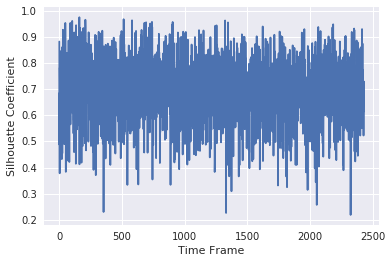

In [57]:
import matplotlib.pyplot as plt

#plt.plot(x_values, silhouette_result)
plt.plot(silhouette_result)
plt.ylabel('Silhouette Coefficient')
plt.xlabel('Time Frame')
plt.show()

In [113]:
from pyspark.mllib.fpm import FPGrowth
data=sc.parallelize(cluster_list)
model = FPGrowth.train(data, 0.0015, 6)   #applying FP growth on transactions
Frequent_item_list = model.freqItemsets().collect()

In [114]:
len(Frequent_item_list) # total number of frequent itemsets

463

In [111]:
# we are only interested in finding frequent itemsets with size>=2 in order to consider as a group travelers
Group_travelers = {}
gp = []
d= {}
l=0
ct = {}
for k in Frequent_item_list:
    if len(k[0]) >=2:
        for l in k[0]:
            Group_travelers[l]=1
            gp.append(l)

In [112]:
len(Group_travelers)  # no.of group travlers

85

## The total group travelers are 133 and we got 85 which is 63%

## Testing Solo travelers data

In [75]:
solo_test_data = sc.textFile("gs://testdatakiana/solo_test.json", 6)

In [76]:
solo_test_data=solo_test_data.map(lambda x:json.loads(x))

In [78]:
temp = []
for x in solo_test_data.collect():
    for j in x:
        temp.append(j)

In [79]:
rdd1 = sc.parallelize(temp)
row_rdd = rdd1.map(lambda x: Row(x))

In [83]:
from pandas import DataFrame
solo_test_df = DataFrame(temp,columns=["Building","ClientMacAddr","Level","lat","lng","localtime"])

In [84]:
len(solo_test_df)

15651

### Accuracy of Clustering algorithm

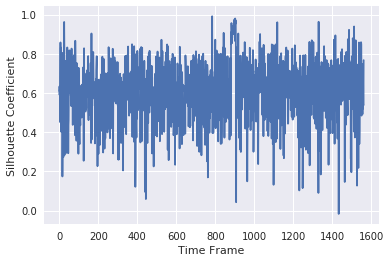

In [86]:
import matplotlib.pyplot as plt

#plt.plot(x_values, silhouette_result)
plt.plot(silhouette_result)
plt.ylabel('Silhouette Coefficient')
plt.xlabel('Time Frame')
plt.show()

In [96]:
from pyspark.mllib.fpm import FPGrowth
data=sc.parallelize(cluster_list)
model = FPGrowth.train(data, 0.0015, 6)   #applying FP growth on transactions
Frequent_item_list = model.freqItemsets().collect()

In [97]:
len(Frequent_item_list) # total number of frequent itemsets

616


Group_travelers = {}
gp = []
d= {}
l=0
ct = {}
for k in Frequent_item_list:
    if len(k[0]) >=2:
        for l in k[0]:
            Group_travelers[l]=1
            gp.append(l)

In [90]:
len(Group_travelers)  # no.of group travlers

0

## Our approach labels all the data points as solo correctly with 100% accuracy